In [1]:
import sys
import torch
import utils
import os
import numpy as np
from torchvision import transforms
from PIL import Image

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('/home/bingxing2/ailab/maiweijian/SynBrain/src/sdxl/generative_models')
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

In [5]:
device = 'cuda'

clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    # version="laion2b_s39b_b160k",
    version="/home/bingxing2/ailab/group/ai4neuro/mindeyev2/open_clip_pytorch_model.bin",
    output_tokens=True,
    only_tokens=False,
)
clip_img_embedder.to(device).eval()

clip_seq_dim = 256
clip_emb_dim = 1664

In [6]:
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from IPython.display import display
import torchvision
from torchvision import transforms

class CLIP_Image_Dataset(Dataset):
    def __init__(self, image_path):
        self.img_data = image_path   #图像path

    def __getitem__(self, idx):
        img = Image.open(self.img_data[idx])  # 一张图像对应1个fmri
        img = TF.to_tensor(img).float()
        return img

    def __len__(self):
        return len(self.img_data)


data_path="/home/bingxing2/ailab/group/ai4neuro/BrainVL/data/processed_data"
batch_size=1000

for subj in [1, 2, 5, 7]:
    save_path = os.path.join("/home/bingxing2/ailab/group/ai4neuro/BrainVL/data/nsd", 'subj0{}'.format(subj))
    
    train_image_path = os.path.join(data_path, 'subj0{}/train_img'.format(subj))
    train_image = np.array([os.path.join(train_image_path, f'{i}.png') for i in range(len(os.listdir(train_image_path)))])
    
    print(f'Train Image Sub{subj}: {train_image.shape}')
    train_dataset = CLIP_Image_Dataset(train_image)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False)
    
    test_image_path = os.path.join(data_path, 'subj0{}/test_img'.format(subj))
        
    test_image = np.array([os.path.join(test_image_path, f'{i}.png') for i in range(len(os.listdir(test_image_path)))])
    print(f'Test Image Sub{subj}: {test_image.shape}')
    test_dataset = CLIP_Image_Dataset(test_image)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=False)
    mode = 'test'
    for test_i, image in enumerate(test_dataloader):
        print(test_i)
        
        with torch.no_grad():
            z, z_pool = clip_img_embedder(image.to(device))
        
        if test_i == 0:
            zs = z.detach().cpu()
            zs_pool = z_pool.detach().cpu()
        else:
            zs = torch.cat((zs, z.detach().cpu()), dim=0)
            zs_pool = torch.cat((zs_pool, z_pool.detach().cpu()), dim=0)

    np.save(os.path.join(save_path, f'nsd_sdxl_clip_{mode}_sub{subj}.npy'), zs.numpy())
    np.save(os.path.join(save_path, f'nsd_sdxl_clip_pool_{mode}_sub{subj}.npy'), zs_pool.numpy())
    del z, zs, zs_pool, image
    
    mode = 'train'
    for train_i, image in enumerate(train_dataloader):
        print(train_i)
        
        with torch.no_grad():
            z, z_pool = clip_img_embedder(image.to(device))
        
        if train_i == 0:
            zs = z.detach().cpu()
            zs_pool = z_pool.detach().cpu()
        else:
            zs = torch.cat((zs, z.detach().cpu()), dim=0)
            zs_pool = torch.cat((zs_pool, z_pool.detach().cpu()), dim=0)

    np.save(os.path.join(save_path, f'nsd_sdxl_clip_{mode}_sub{subj}.npy'), zs.numpy())
    np.save(os.path.join(save_path, f'nsd_sdxl_clip_pool_{mode}_sub{subj}.npy'), zs_pool.numpy())
    del z, zs, zs_pool, image

Train Image Sub1: (9000,)
Test Image Sub1: (1000,)
0
0
1
2
3
4
5
6
7
8
Train Image Sub2: (9000,)
Test Image Sub2: (1000,)
0
0
1
2
3
4
5
6
7
8
Train Image Sub5: (9000,)
Test Image Sub5: (1000,)
0
0
1
2
3
4
5
6
7
8
Train Image Sub7: (9000,)
Test Image Sub7: (1000,)
0
0
1
2
3
4
5
6
7
8


In [3]:
subj = 1
data_path = "/home/bingxing2/ailab/group/ai4neuro/BrainVL/data/processed_data"
train_image_path = os.path.join(data_path, 'subj0{}/train_img'.format(subj))
train_image_path = np.array([os.path.join(train_image_path, f'{i}.png') for i in range(len(os.listdir(train_image_path)))])

transform = transforms.ToTensor()

tensors = []
for path in train_image_path[:10]:
    img = Image.open(path).convert('RGB')   # 保证RGB三通道
    tensor = transform(img)                 # 转为 tensor [3, H, W], float32
    tensors.append(tensor)

image_batch = torch.stack(tensors)

clip_target = clip_img_embedder(image_batch.to(device)) #!处理IMAGE
pass

In [4]:
from models import *
from omegaconf import OmegaConf
from generative_models.sgm.models.diffusion import DiffusionEngine

# prep unCLIP
config = OmegaConf.load("generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(network_config=network_config,
                       denoiser_config=denoiser_config,
                       first_stage_config=first_stage_config,
                       conditioner_config=conditioner_config,
                       sampler_config=sampler_config,
                       scale_factor=scale_factor,
                       disable_first_stage_autocast=disable_first_stage_autocast)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(device)

ckpt_path = f'/home/bingxing2/ailab/group/ai4neuro/mindeyev2/unclip6_epoch0_step110000.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

batch={"jpg": torch.randn(1,3,1,1).to(device), # jpg doesnt get used, it's just a placeholder
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
print("vector_suffix", vector_suffix.shape)

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


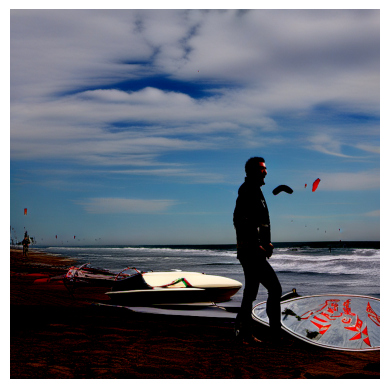

In [10]:
import matplotlib.pyplot as plt

clip_ = clip_target[:1]

for i in range(10):
    samples = utils.unclip_recon(clip_target[i].unsqueeze(0),
                        diffusion_engine,
                        vector_suffix,
                        num_samples=1)

    # plt.figure(figsize=(2,2))
    plt.imshow(transforms.ToPILImage()(samples[0]))
    plt.axis('off')
    plt.show()